# TensorFlow2.0教程-使用RNN生成文本

本教程演示了如何使用基于字符的RNN生成文本。我们将使用Andrej Karpathy的“循环神经网络的不合理有效性”中的莎士比亚写作数据集。给定来自该数据的一系列字符（“Shakespear”），训练模型以预测序列中的下一个字符（“e”）。通过重复调用模型可以生成更长的文本序列。

本教程包含使用tf.keras实现的可运行代码和急切执行。以下是本教程中的模型训练了30个纪元时的示例输出，并以字符串“Q”开头：

<pre>
QUEENE:
I had thought thou hadst a Roman; for the oracle,
Thus by All bids the man against the word,
Which are so weak of care, by old care done;
Your children were in your holy love,
And the precipitation through the bleeding throne.

BISHOP OF ELY:
Marry, and will, my lord, to weep in such a one were prettiest;
Yet now I was adopted heir
Of the world's lamentable day,
To watch the next way with his father with his face?

ESCALUS:
The cause why then we are all resolved more sons.

VOLUMNIA:
O, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, it is no sin it should be dead,
And love and pale as any will to that word.

QUEEN ELIZABETH:
But how long have I heard the soul for this world,
And show his hands of life be proved to stand.

PETRUCHIO:
I say he look'd on, if I must be content
To stay him from the fatal of our country's bliss.
His lordship pluck'd from this sentence then for prey,
And then let us twain, being the moon,
were she such a case as fills m
</pre>

虽然有些句子是语法上的，但大多数句子都没有意义。该模型尚未学习单词的含义，但考虑：

该模型基于字符。培训开始时，模型不知道如何拼写英语单词，或者单词甚至是文本单元。

输出的结构类似于文本的播放块，通常以说话者名称开头，所有大写字母都类似于数据集。

如下所示，模型是针对小批量文本（每个100个字符）进行训练的，并且仍然能够生成具有连贯结构的更长文本序列。

## 开始

### 导入TensorFlow

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

import numpy as np
import os
import time

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        print(gpu)
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### 下载莎士比亚数据集
更改以下行以在您自己的数据上运行此代码

In [3]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

### 观察数据

首先， 观察文字:

In [4]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [5]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [6]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

65 unique characters


## 处理文本

### 矢量化文本
在训练之前，我们需要将字符串映射到数字表示。创建两个查找表：一个将字符映射到数字，另一个用于数字到字符。

In [7]:
# Creating a mapping from unique characters to indices
char2idx = {char:index for index, char in enumerate(vocab)}
idx2char = np.array(vocab)

# 文本str -> int
text_as_int = np.array([char2idx[c] for c in text])

In [8]:
text_as_int.shape

(1115394,)

现在我们有一个每个字符的整数表示。请注意，我们将字符映射为从0到的索引len(unique)。

In [9]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [10]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'First Citizen' ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


### 预测任务


给定一个字符或一系列字符，最可能的下一个字符是什么？这是我们正在训练模型执行的任务。模型的输入将是一系列字符，我们训练模型以预测输出 - 每个时间步的后续字符。

由于RNN维持一个取决于之前看到的元素的内部状态，给定此时计算的所有字符，下一个字符是什么？

### 创建培训示例和目标
接下来将文本划分为示例序列。每个输入序列将包含seq_length文本中的字符。

对于每个输入序列，相应的目标包含相同长度的文本，除了向右移动一个字符。

所以把文本分成几块seq_length+1。例如，假设seq_length是4，我们的文本是“你好”。输入序列是“Hell”，目标序列是“ello”。

为此，首先使用该tf.data.Dataset.from_tensor_slices函数将文本向量转换为字符索引流。

In [11]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//seq_length

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):  # 前5个字符
  print(idx2char[i.numpy()])

F
i
r
s
t


该batch方法可以让我们轻松地将这些单个字符转换为所需大小的序列。

In [12]:
# 每101个字符 会生成一对(X, Y)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


对于每个序列，复制并移动它以形成输入和目标文本，map方法是使用该方法将简单函数应用于每个批处理：

In [13]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

打印第一个示例输入和目标值：

In [14]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


这些矢量的每个索引作为一个时间步骤处理。对于时间步骤0的输入，模型接收“F”和trys的索引以预测“i”的索引作为下一个字符。在下一个时间步，它做同样的事情，但RNN除了当前输入字符之外还考虑前一步骤上下文。

In [15]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 18 ('F')
  expected output: 47 ('i')
Step    1
  input: 47 ('i')
  expected output: 56 ('r')
Step    2
  input: 56 ('r')
  expected output: 57 ('s')
Step    3
  input: 57 ('s')
  expected output: 58 ('t')
Step    4
  input: 58 ('t')
  expected output: 1 (' ')


### 创建培训批次
我们过去常常tf.data将文本拆分为可管理的序列。但在将这些数据输入模型之前，我们需要对数据进行混洗并将其打包成批。


In [16]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## 建立模型


使用tf.keras.Sequential来定义模型。对于这个简单的例子，三层用于定义我们的模型：

- tf.keras.layers.Embedding：输入图层。一个可训练的查找表，它将每个字符的数字映射到具有embedding_dim维度的向量;
- tf.keras.layers.GRU：一种具有大小的RNN units=rnn_units（您也可以在此处使用LSTM层。）
- tf.keras.layers.Dense：输出层，带vocab_size输出。

In [17]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [18]:
vocab_size

65

In [19]:
tf.keras.layers.Embedding?

Init signature:
tf.keras.layers.Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    **kwargs,
)
Docstring:     
Turns positive integers (indexes) into dense vectors of fixed size.

e.g. `[[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]`

This layer can only be used as the first layer in a model.

Example:

```python
model = Sequential()
model.add(Embedding(1000, 64, input_length=10))
# the model will take as input an integer matrix of size (batch,
# input_length).
# the largest integer (i.e. word index) in the input should be no larger
# than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch
# dimension.

input_array = np.random.randint(1000, size=(32, 10))

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
assert output_array.shape == (32, 10, 64)
```

Argume

In [20]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              # 不指定input_length, 为了测试时生成不同长度文本考虑
                              batch_input_shape=[batch_size, None]),  
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    # tf.keras.layers.GRU(rnn_units,
    #                     return_sequences=True,
    #                     stateful=True,
    #                     recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [21]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

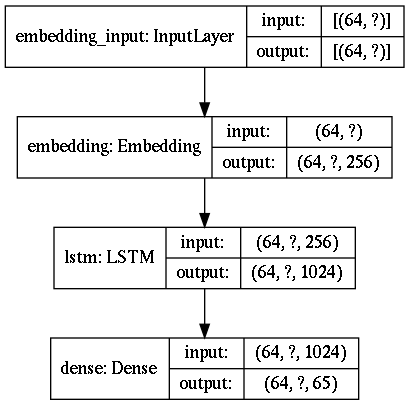

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

对于每个字符，模型查找嵌入，以嵌入作为输入一次运行GRU，并应用密集层生成预测下一个字符的对数似然的logits：

<img src="https://tensorflow.org/tutorials/beta/text/images/text_generation_training.png">通过模型的数据图</img>


![通过模型的数据图](https://tensorflow.org/tutorials/beta/text/images/text_generation_training.png)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


## 测试模型
现在运行模型以查看它的行为符合预期。

首先检查输出的形状：

In [24]:
for input_example_batch, target_example_batch in dataset.take(1):
    print(input_example_batch.shape)
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100)
(64, 100, 65) # (batch_size, sequence_length, vocab_size)


在上面的例子中，输入的序列长度是，100但模型可以在任何长度的输入上运行：

为了从模型中获得实际预测，我们需要从输出分布中进行采样，以获得实际的字符索引。此分布由字符词汇表上的logits定义。
> 注意：从这个分布中进行采样非常重要，因为采用分布的argmax可以很容易地将模型卡在循环中。

尝试批处理中的第一个示例：

In [25]:
example_batch_predictions[0]

<tf.Tensor: shape=(100, 65), dtype=float32, numpy=
array([[ 0.00404359,  0.00288558,  0.00215357, ..., -0.00045593,
        -0.00293113, -0.00260316],
       [ 0.00073711,  0.00550455,  0.00546801, ...,  0.00323724,
         0.00089605, -0.00147596],
       [ 0.00346867,  0.00400022,  0.00560515, ...,  0.00242463,
         0.00024617, -0.00369232],
       ...,
       [ 0.00267898,  0.00043139, -0.00302298, ..., -0.00372706,
         0.00450641,  0.00241301],
       [ 0.00282291, -0.00078044, -0.00247648, ..., -0.00019255,
         0.00312746, -0.00044447],
       [-0.0004436 ,  0.00416891,  0.00081265, ...,  0.00518154,
         0.00840197, -0.0064987 ]], dtype=float32)>

In [26]:
# 需要使用未归一化(softmax)的数据
tf.random.categorical?

Signature:
tf.random.categorical(
    logits,
    num_samples,
    dtype=None,
    seed=None,
    name=None,
)
Docstring:
Draws samples from a categorical distribution.

Example:

```python
# samples has shape [1, 5], where each value is either 0 or 1 with equal
# probability.
samples = tf.random.categorical(tf.math.log([[0.5, 0.5]]), 5)
```

Args:
  logits: 2-D Tensor with shape `[batch_size, num_classes]`.  Each slice
    `[i, :]` represents the unnormalized log-probabilities for all classes.
  num_samples: 0-D.  Number of independent samples to draw for each row slice.
  dtype: integer type to use for the output. Defaults to int64.
  seed: A Python integer. Used to create a random seed for the distribution.
    See `tf.compat.v1.set_random_seed` for behavior.
  name: Optional name for the operation.

Returns:
  The drawn samples of shape `[batch_size, num_samples]`.
File:      ~/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/random_ops.py
Type:      function


In [27]:
# 对第一个样本进行随机采样  [batch_size, num_classes]=(100, 65)  - > (100 , 1)
# 使用argmax 会生成相同的文本
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
print(sampled_indices.shape)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

(100, 1)


这使我们在每个时间步都预测下一个字符索引：

In [28]:
sampled_indices

array([37, 40,  4, 15, 22,  4, 18,  2, 31,  7, 11, 16, 50, 47,  7, 28, 20,
       54, 21, 61, 50, 35, 47,  3, 59,  9, 53, 10, 34, 31, 51, 52,  4, 40,
        1, 48, 37, 63, 22, 61, 49, 40, 17, 32, 14,  6, 29, 34, 33, 55, 41,
       57, 15, 16, 53, 50, 46, 61, 18, 58, 15,  8,  8, 62,  6, 51, 24,  7,
       39, 19, 24, 29, 51,  4, 50, 57,  0, 46, 58, 14, 35, 52,  7,  8, 51,
       17, 25, 30, 61, 44, 44,  2, 14, 36, 52, 22,  8, 19, 22, 33])

解码这些以查看此未经训练的模型预测的文本：

In [29]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'nd it to be true,\nI never thought it possible or likely;\nBut see, while idly I stood looking on,\nI f'

Next Char Predictions: 
 'Yb&CJ&F!S-;Dli-PHpIwlWi$u3o:VSmn&b jYyJwkbETB,QVUqcsCDolhwFtC..x,mL-aGLQm&ls\nhtBWn-.mEMRwff!BXnJ.GJU'


## 训练模型

此时，问题可以被视为标准分类问题。给定先前的RNN状态，以及此时间步的输入，预测下一个字符的类。

### 附加优化器和损失函数

标准tf.keras.losses.sparse_categorical_crossentropy损失函数在这种情况下有效，因为它应用于预测的最后一个维度。

因为我们的模型返回logits，所以我们需要设置from_logits标志。

In [30]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.174947


In [31]:
example_batch_loss.numpy().shape

(64, 100)

使用该tf.keras.Model.compile方法配置培训过程。我们将使用tf.keras.optimizers.Adam默认参数和损失函数。

In [32]:
model.compile(optimizer='adam', loss=loss)

### 配置检查点

使用a tf.keras.callbacks.ModelCheckpoint确保在培训期间保存检查点：

In [33]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)  # 保留每个epoch的weights

### 执行培训

为了使训练时间合理，使用10个时期来训练模型。在Colab中，将运行时设置为GPU以便更快地进行训练。

In [34]:
EPOCHS=50

In [35]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Train for 172 steps
Epoch 1/50
172/172 [==============================] - 41s 240ms/step - loss: 2.6168
Epoch 2/50
172/172 [==============================] - 41s 236ms/step - loss: 1.8878
Epoch 3/50
172/172 [==============================] - 40s 230ms/step - loss: 1.6360
Epoch 4/50
172/172 [==============================] - 39s 229ms/step - loss: 1.5030
Epoch 5/50
172/172 [==============================] - 40s 231ms/step - loss: 1.4242
Epoch 6/50
172/172 [==============================] - 40s 230ms/step - loss: 1.3693
Epoch 7/50
172/172 [==============================] - 39s 230ms/step - loss: 1.3249
Epoch 8/50
172/172 [==============================] - 40s 231ms/step - loss: 1.2856
Epoch 9/50
172/172 [==============================] - 39s 229ms/step - loss: 1.2515
Epoch 10/50
172/172 [==============================] - 39s 229ms/step - loss: 1.2163
Epoch 11/50
172/172 [==============================] - 40s 232ms/step - loss: 1.1813
Epoch 12/50
172/172 [==============================] -

## 生成文本

### 恢复最新的检查点


要使此预测步骤简单，请使用批处理大小1。

由于RNN状态从时间步长传递到时间步的方式，模型一旦构建就只接受固定的批量大小。

要使用不同的模型运行模型batch_size，我们需要重建模型并从检查点恢复权重。


In [36]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_50'

In [37]:
# 用于生成文本 的 模型
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


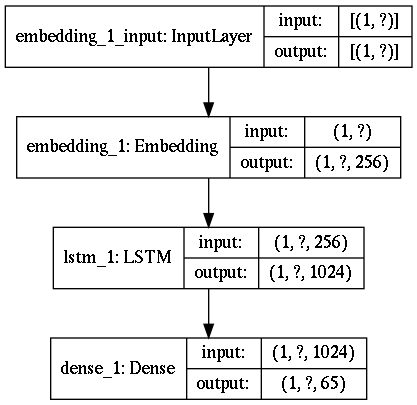

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True)

预测循环
以下代码块生成文本：

- 它首先选择一个起始字符串，初始化RNN状态并设置要生成的字符数。

- 使用起始字符串和RNN状态获取下一个字符的预测分布。

- 然后，使用分类分布来计算预测字符的索引。使用此预测字符作为模型的下一个输入。

- 模型返回的RNN状态被反馈到模型中，以便它现在具有更多上下文，而不是仅有一个单词。在预测下一个单词之后，修改后的RNN状态再次反馈到模型中，这是它从先前预测的单词获得更多上下文时的学习方式。






![要生成文本，模型的输出将反馈到输入](https://tensorflow.org/tutorials/beta/text/images/text_generation_sampling.png)
查看生成的文本，您将看到模型知道何时大写，制作段落并模仿类似莎士比亚的写作词汇。由于训练时代数量较少，尚未学会形成连贯的句子。

In [40]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  print("输入字符:", input_eval.shape)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  # 初始化RNN的状态向量
  model.reset_states()
  for i in range(num_generate):
      # input (1, None)  out (1, None, 65) 
      predictions = model(input_eval)  
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)  # [None, 65]

      # using a categorical distribution to predict the word returned by the model
      predictions = predictions / temperature
      # (None, 1)[-1, 0]
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      # X^<t> = y^<t-1>
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [41]:
print(generate_text(model, start_string=u"R"))

输入字符: (1, 1)
RICHAMIO:
No, noble prince, thou shouldst have met again
And glink thee, tire-tremble. How long have you this
My words disbench'd you not.

CORIOLANUS:
I'll say ith the deed?

Second Watchman:
To-morrow this:
Upon my life, Pompey? it is hoow, when I should break on a
gaf vex him once again;
For though you live to see your kindred's tears:
As when withir
Vure one and white posterns or two
ISABELLA:
Show me how, good father.

DUKE VINCENTIO:
By this my body's goods, and longing, stabbed with a
brain'd stephend hath got the way,
Heaven and of which pines I plead
And he shall speak for them, it should proceed:
I'll draw the cause with you, by your leave,
That we have no discover'd, it shall be studned at his hat!
O, tell me, didst thou not aspirit,
While I stand fooling in one less? or I swear perform'd you from a maid.

VIRGILIA:
The sway is to make his and look in heaven.
O woman' when
Thy by my soul's red jost to serve
Of his own good curse my misfit like
A place of statelf

你可以做的最简单的事情是改善结果，以便更长时间地训练它（尝试EPOCHS=30）。

您还可以尝试使用不同的起始字符串，或尝试添加另一个RNN图层以提高模型的准确性，或者调整温度参数以生成更多或更少的随机预测。



## 上述训练程序很简单，但不会给你太多控制。

所以现在您已经了解了如何手动运行模型，让我们解压缩训练循环，并自己实现。例如，如果要实施课程学习以帮助稳定模型的开环输出，这就是一个起点。

我们将用于tf.GradientTape跟踪渐变。您可以通过阅读热切的执行指南来了解有关此方法的更多信息。

该程序的工作原理如下：

- 首先，初始化RNN状态。我们通过调用tf.keras.Model.reset_states方法来完成此操作。

- 接下来，迭代数据集（逐批）并计算与每个数据集关联的预测。

- 打开a tf.GradientTape，并计算该上下文中的预测和损失。

- 使用该tf.GradientTape.grads方法计算相对于模型变量的损失梯度。

- 最后，使用优化器的tf.train.Optimizer.apply_gradients方法向下迈出一步。



In [ ]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [ ]:
optimizer = tf.keras.optimizers.Adam()

In [ ]:
@tf.function
def train_step(inp, target):
  with tf.GradientTape() as tape:
    predictions = model(inp)
    loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            target, predictions, from_logits=True))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss

In [ ]:
# Training step
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  # initializing the hidden state at the start of every epoch
  # initally hidden is None
  hidden = model.reset_states()

  for (batch_n, (inp, target)) in enumerate(dataset):
    loss = train_step(inp, target)

    if batch_n % 100 == 0:
      template = 'Epoch {} Batch {} Loss {}'
      print(template.format(epoch+1, batch_n, loss))

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))

  print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model.save_weights(checkpoint_prefix.format(epoch=epoch))